# triangle_data_structure

> Data structure for triangulation

See https://cs184.eecs.berkeley.edu/public/sp22/lectures/lec-8-mesh-representations-and-geometr/lec-8-mesh-representations-and-geometr.pdf



In [ ]:
#| default_exp triangle

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [ ]:
#| hide
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import spatial

In [ ]:
#| export

# helper functions

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

## create some test data using scipy

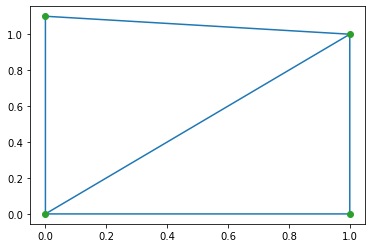

In [ ]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])

tri = spatial.Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

plt.show()

In [ ]:
# attributes

tri.points, tri.simplices, tri.neighbors

(array([[0. , 0. ],
        [0. , 1.1],
        [1. , 0. ],
        [1. , 1. ]]),
 array([[2, 3, 0],
        [3, 1, 0]], dtype=int32),
 array([[ 1, -1, -1],
        [-1,  0, -1]], dtype=int32))

In [ ]:
# methods

tri.find_simplex, tri.add_points

(<bound method Delaunay.find_simplex of <scipy.spatial._qhull.Delaunay object>>,
 <bound method Delaunay.add_points of <scipy.spatial._qhull.Delaunay object>>)

## List of Pts + Triangles

Simplest data structure for a triangulation:

- Vertices = [($x_0$,$y_0$), ... ]
- Triangles = [(vertex id 1, vertex id 2, vertex id 3), ...]

From this data, one can compute the neighbor relationship of triangles
- Triangle neighbors = [(triangle id 1, triangle id 2, triangle id 3), ...]

How should we index things? We want to be able to refer to points and faces consistently over time series of meshes, so just using their index in the list is no good. We shall use dictionaries instead.

In [ ]:
#| export

def get_neighbors(faces):
    """compute neighbor list by checking which triangles share 2 vertices. Note: this is quadratic"""
    neighbors = {key: [nghb_key for nghb_key, pot_nghb in faces.items()
                   if len(set(pot_nghb)&set(face)) == 2]
             for key, face in faces.items()}
    return neighbors

class ListOfPts:
    def __init__(self, points, faces, neighbors=None):
        # if we pass lists, automatically assign ids to triangles and vertices
        points = points if type(points) is dict else {ix: x for ix, x in enumerate(points)}
        faces = faces if type(faces) is dict else {ix: x for ix, x in enumerate(faces)}
        self.points, self.faces = (points, faces)
        self.neighbors = get_neighbors(faces) if neighbors is None else neighbors
        
    # some basic methods
    def remove_pt(self, pt_id):
        del self.points[pt_id]
        self.faces = {key: face for key, face in self.faces.items() if not pt_id in face}
        self.neighbors = get_neighbors(self.faces) 

In [ ]:
test = ListOfPts(list(tri.points), list(tri.simplices))

print(test.faces, test.neighbors)

test.remove_pt(1)

print(test.faces, test.neighbors)

{0: array([2, 3, 0], dtype=int32), 1: array([3, 1, 0], dtype=int32)} {0: [1], 1: [0]}
{0: array([2, 3, 0], dtype=int32)} {0: []}


## Half-edge

More complicated operations (e.g. flipping triangles) are a pain to implement with this simple data structure, which furthermore does not contain edges. We now build a half-edge data structure class.

In [ ]:
#| export
def sort_vertices(vertices: np.ndarray) -> np.ndarray:
    """Sort vertices of cycle clockwise by polar angle. Guaranteed to work for non-convex polygons."""
    phis = [np.arctan2(*x) for x in vertices]
    return np.stack([x for _, x in sorted(zip(phis, vertices))])

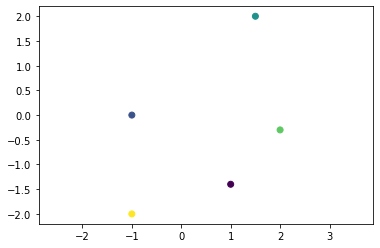

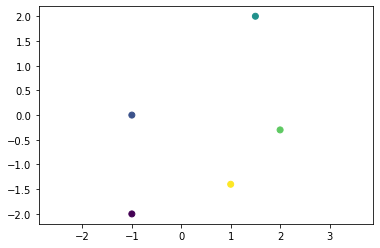

In [ ]:
pts = np.array([[1,-1.4], [-1, 0], [1.5, 2], [2, -.3], [-1, -2]])

plt.scatter(*pts.T, c=np.arange(5))
plt.axis("equal")
plt.show()

pts_sorted = sort_vertices(pts)

plt.scatter(*pts_sorted.T, c=np.arange(5))
plt.axis("equal")
plt.show()

A half-edge contains the following data:
- `next` - the next half edge
- `twin` - the twin half edge
- `cell` - the cell it belongs to
- `vertices` - start and end vertex

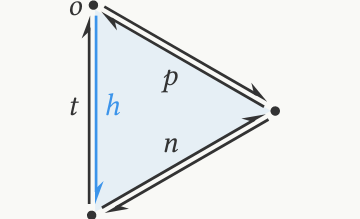
See https://jerryyin.info/geometry-processing-algorithms/half-edge/

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, List, Tuple
from nptyping import NDArray, Int, Float, Shape

@dataclass
class HalfEdge:
    """Attribute holder class for half edges. Attributes point to other items."""
    _heid : int
    nxt: int
    twin: int
    cell: Union[int, None] # None if it's a boundary
    vertices: tuple # 0 is origin, 1 is destination
        
@dataclass
class Vertex:
    """Attribute holder class for vertices. Attributes point to other items."""
    _vid : int
    coords : NDArray[Shape["2"], Float]
    incident : HalfEdge

@dataclass
class Face:
    """Attribute holder class for faces. Attributes point to other items."""
    _fid : int
    hes : List[HalfEdge]
        
@dataclass
class Edge:
    """Attribute holder class for edges. Main point is to use it to store variables for ODE evolution"""
    _eid : int
    hes : Tuple[HalfEdge, HalfEdge]
    variables : dict
        
    def __post_init__(self):
        assert (hes[0].twin == hes[1]._heid) and (hes[1].twin == hes[0]._heid)

In [ ]:
he = HalfEdge(10031, 1, 4, 2, (2, 3))

v = Vertex(10, np.array([2.0, 2.1]), he)
he_new = HalfEdge(10034, 1, 4, 2, (2, 3))

v.incident = he_new # we can edit the incident edge
v

Vertex(_vid=10, coords=array([2. , 2.1]), incident=HalfEdge(_heid=10034, nxt=1, twin=4, cell=2, vertices=(2, 3)))

In [ ]:
v.incident == he_new, not (v.incident == he)

(True, True)

The additional data provided by the half-edge mesh structure will be very helpful further on. In order to initialize the half-edge data structure, we use the `ListofPts` class from above.

TO DO: figure out how to deal with edge id's, edge variables.

In [ ]:
#| 

Help on _SpecialGenericAlias in module typing:

typing.List
    A generic version of list.

